# Problem 2B: Energy vs Displacement of Ti Atom
Using the equilibrium lattice parameter from part (A), plot the energy as a function of displacement of the Ti atom along one of the cubic lattice directions, allowing the O atoms to fully relax for each displacement. Report the Ti displacement at which the total energy is at a minimum. What is the energy difference between this configuration and the minimum-energy configuration from part (A)? Be aware that for PbTiO3, the Ti displacement will be very small.

In [4]:
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import ase 
from ase import Atom, Atoms
from ase.visualize import view
from ase.io import read, write

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Main Calculation
For this part, we will need to, at each step, move the `Ti` atom along an axis by some step size `h`. Then at each step, we need to run a `relaxation` routine for the oxygen atoms, while leaving the `Ti` and `Pb` atoms field. Then we need to write the energy values out to eventually get energy vs displacement. 

In [48]:
def struct(lattice_constant):
    """ generates the PbTiO3 structure in ASE """
    
    symbols = ['Pb', 'Ti', 'O', 'O', 'O']
    # simple cubic structure 
    cell = lattice_constant * np.identity(3, dtype = 'float')
    
    # positions in lattice constant units 
    Pb_pos = [0.00, 0.00, 0.00]
    Ti_pos = [0.50, 0.50, 0.50]
    O1_pos = [0.50, 0.50, 0.00] 
    O2_pos = [0.50, 0.00, 0.50]
    O3_pos = [0.00, 0.50, 0.50]
    
    positions_alat = [Pb_pos, Ti_pos, O1_pos, O2_pos, O3_pos]
    PbTiO3 = Atoms(symbols = symbols, scaled_positions = positions_alat, cell = cell)
    
    return PbTiO3

## Helper Files

In [11]:
def parse_output(outfile):
    """ Parses the quantum espresso output file
        Returns a dictionary with relevants in key-value pairs
        such as {'energy': energy_value}
    """
    
    with open(outfile, 'r') as outf:
        for line in outf:
            if (line.lower().startswith('     lattice parameter (alat)')):
                lattice_constant = float(line.split()[-2]) * 0.529177
            if (line.lower().startswith('!    total energy')):
                total_energy = float(line.split()[-2]) * 13.605698066
                
    result = {'energy': total_energy, 'lattice': lattice_constant}
    return result 

In [12]:
def lattice_subs(file, lattice_parameter, offset = '0'):
    """ opens input file file and changes value for lattice constant """
    
    # check for proper input 
    assert type(lattice_parameter) == 'int' or 'numpy.int64', 'Provide k-points input as int or numpy.int64' 
    lat_string = "    celldm(1) = " + str(lattice_parameter) + "\n"
    
    # open the file 
    with open(file,'r') as input_file:
        lines = input_file.readlines()
    with open(file, 'w') as input_file:
        for line in lines:
            if line.split()[0] == 'celldm(1)':
                # write the k_points string 
                input_file.write(lat_string)
            else:
                input_file.write(line)  

In [28]:
def ti_pos_update(file, displacement):
    """ opens input file `file` and changes titanium position """
    
    string = str(0.5 + displacement) 
    
    # open the file 
    with open(file, 'r') as input_file:
        lines = input_file.readlines() 
    with open(file, 'w') as input_file:
        for line in lines:
            if line.split()[0] == 'Ti' and line.split()[1] == '0.50':
                input_file.write('  Ti  0.50  0.50  ' + string + ' 0 0 0\n')
            else:
                input_file.write(line)

In [18]:
def energy_calc(displacement_array):
    """ 
    finds energy as a function of displacement 
    """
    
    # declare force array of same size as cut off array 
    energy_array = np.zeros(len(displacement_array))
    
    for i in range(len(displacement_array)):
        # update input file 
        ti_pos_update("pbtio3.relax.in", displacement_array[i])
        
        # call pw.x 
        subprocess.run('pw.x -in pbtio3.relax.in > pbtio3.relax.out', shell=True)
        
        # parse output file 
        result = parse_output('pbtio3.relax.out')
        
        # get force and append to array 
        energy_array[i] = result['energy']
        
    return energy_array

### Running the calculations...

In [89]:
displacement_array = np.linspace(-0.001, 0.001, 10)
displacement_array

array([-0.001     , -0.00077778, -0.00055556, -0.00033333, -0.00011111,
        0.00011111,  0.00033333,  0.00055556,  0.00077778,  0.001     ])

In [90]:
energy = energy_calc(displacement_array)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

In [146]:
energy

array([-15170.77315053, -15170.77316155, -15170.77316985, -15170.77317543,
       -15170.77317829, -15170.7731806 , -15170.77317829, -15170.77317298,
       -15170.77316496, -15170.77315393])

## Preliminary Plotting

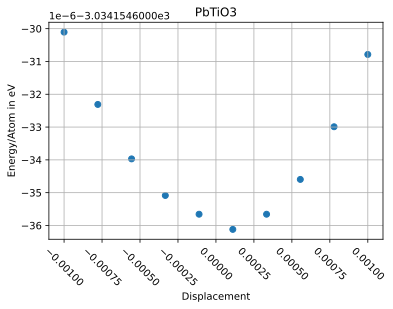

In [119]:
plt.scatter(displacement_array, energy/5)
plt.grid()
plt.xlabel('Displacement')
plt.ylabel('Energy/Atom in eV')
plt.title('PbTiO3')
plt.xticks(rotation = -45)
plt.savefig('PbTiO3_energy.pdf')

## Fitting: Taylor Series

In [46]:
from scipy.optimize import curve_fit

In [61]:
def murnaghan(a, a0, B0, B0_prime, E0):
    coeff_1 = 9*B0*a0**3/16/4
    brac_1 = ((a0/a)**2 - 1)**3 * B0_prime 
    brac_2 = ((a0/a)**2 - 1)**2 * (6 - 4*(a0/a)**2)
    return E0 + coeff_1 * (brac_1 + brac_2)

In [127]:
def taylor(x, x_0, beta, c):
    return c + beta*(x-x_0)**2 

In [142]:
p_opt, p_cov = curve_fit(taylor, displacement_array*100000, energy/5*1000, [1.0, -0.5, -2000])

/Users/vinhtran/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


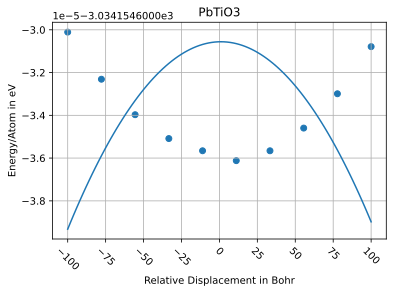

In [143]:
plt.scatter(displacement_array*100000, energy/5)
x = np.linspace(-0.001, 0.001, 100)*100000
plt.plot(x, taylor(x, *p_opt))
plt.grid()
plt.xlabel('Relative Displacement in Bohr')
plt.ylabel('Energy/Atom in eV')
plt.title('PbTiO3')
plt.xticks(rotation = -45)
plt.savefig('PbTiO3_energy.pdf')

In [88]:
p_opt[0] # Bohr

1.2858059796612624e-05

In [113]:
p_opt

array([-2.26506956e-01, -5.89149316e+00,  1.30041301e+01, -3.03348736e+03])

In [116]:
p_cov

array([[ 5.92226989e-10, -1.81614689e-09, -8.04094130e-06,
         4.99803514e-12],
       [-1.81614689e-09,  8.24281330e-07,  1.97269369e-04,
         3.06543476e-10],
       [-8.04094130e-06,  1.97269369e-04,  8.73404801e-01,
        -5.42885183e-07],
       [ 4.99803514e-12,  3.06543476e-10, -5.42885183e-07,
         1.51849343e-12]])

## Results
We end up finding from this fit that the ideal lattice constant is $a_0 = 3.982$ Angstrom which is very comparable to the experimental lattice constant of $a_0 = 3.97$ Angstrom. Very exciting! 